Nous pouvons commencer par :

- Organisation :

Préparer ton environnement de travail (Python, bibliothèques nécessaires, MLFlow, plateforme Cloud choisie).
Télécharger et explorer les données Open Source pour comprendre leur structure.

- Développement des modèles :

Construire le premier modèle simple (régression logistique).
Passer au modèle avancé (deep learning), avec tests sur différents word embeddings et éventuellement BERT.

- MLOps :

Configurer MLFlow pour suivre les expérimentations.
Planifier et intégrer un pipeline CI/CD.

- Déploiement :

Mettre en place l’API pour servir le modèle choisi.
Configurer le suivi des performances avec Azure Application Insights.

- Documentation et présentation :

Rédiger les supports pour l’audience non technique.
Travailler sur l'article de blog mettant en avant le projet et les méthodologies MLOps.

In [1]:
pip install mlflow flask gunicorn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow keras torch transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install streamlit

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [5]:
import mlflow
print(mlflow.__version__)

2.18.0


In [6]:
import mlflow
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [7]:
import pandas as pd

# Charger les données
data_path = "./data/training.1600000.processed.noemoticon.csv"  # Modifier le chemin si nécessaire
df = pd.read_csv(data_path, encoding='latin1')

# Aperçu des données
print(df.head())
print(df.info())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [8]:
# Renommer les colonnes
df.columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']

# Vérifier les données après renommage
print(df.head())

   sentiment          id                          date     query  \
0          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   

            user                                               text  
0  scotthamilton  is upset that he can't update his Facebook by ...  
1       mattycus  @Kenichan I dived many times for the ball. Man...  
2        ElleCTF    my whole body feels itchy and like its on fire   
3         Karoli  @nationwideclass no, it's not behaving at all....  
4       joy_wolf                      @Kwesidei not the whole crew   


In [9]:
# Garder uniquement les colonnes utiles
df = df[['sentiment', 'text']]

# Vérification
print(df.head())

   sentiment                                               text
0          0  is upset that he can't update his Facebook by ...
1          0  @Kenichan I dived many times for the ball. Man...
2          0    my whole body feels itchy and like its on fire 
3          0  @nationwideclass no, it's not behaving at all....
4          0                      @Kwesidei not the whole crew 


In [10]:
# Vérification de la distribution des classes
print(df['sentiment'].value_counts())

sentiment
4    800000
0    799999
Name: count, dtype: int64


In [11]:
# Remapper les valeurs de sentiment
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})

In [12]:
# Vérification de la distribution des classes
print(df['sentiment'].value_counts())

sentiment
1    800000
0    799999
Name: count, dtype: int64


In [13]:
import re

def clean_text(text):
    # Supprimer les URL
    text = re.sub(r'http\S+', '', text)
    # Supprimer les mentions
    text = re.sub(r'@\w+', '', text)
    # Supprimer les caractères spéciaux
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Supprimer les espaces multiples
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Appliquer le nettoyage
df['text'] = df['text'].apply(clean_text)

# Vérification après nettoyage
print(df.head())

   sentiment                                               text
0          0  is upset that he cant update his Facebook by t...
1          0  I dived many times for the ball Managed to sav...
2          0     my whole body feels itchy and like its on fire
3          0  no its not behaving at all im mad why am i her...
4          0                                 not the whole crew


In [14]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['sentiment']

# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Données d'entraînement :", len(X_train))
print("Données de test :", len(X_test))

Données d'entraînement : 1279999
Données de test : 320000


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import seaborn as sns

# Charger les données (remplacez df par votre dataset)
# df = pd.read_csv("votre_fichier.csv")

# Séparer les données
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Données d'entraînement :", len(X_train))
print("Données de test :", len(X_test))

# Étape 1 : Transformer les données textuelles
vectorizer = CountVectorizer(stop_words='english', max_features=10000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Étape 2 : Entraîner le modèle
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_vect, y_train)

# Étape 3 : Prédire et évaluer
y_pred = model.predict(X_test_vect)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Enregistrer dans MLflow
with mlflow.start_run():
    # Loguer le modèle
    mlflow.sklearn.log_model(model, "logistic_regression_model")
    
    # Loguer les métriques
    mlflow.log_metric("accuracy", accuracy)
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # Éviter les clés comme 'accuracy' ou 'macro avg'
            for metric_name, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}", value)
    
    # Loguer les paramètres
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)
    mlflow.log_param("model_max_iter", model.max_iter)
    
    # Étape 4 : Générer et enregistrer des graphiques

    # 1. Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure()
    plt.title("Confusion Matrix")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix.png")

    # 2. Courbe ROC
    y_probs = model.predict_proba(X_test_vect)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title("ROC Curve")
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve.png")
    plt.close()
    mlflow.log_artifact("roc_curve.png")

    # 3. Histogramme des prédictions
    plt.figure()
    plt.title("Prediction Histogram")
    plt.hist(y_probs, bins=10, alpha=0.7, label="Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.savefig("prediction_histogram.png")
    plt.close()
    mlflow.log_artifact("prediction_histogram.png")


Données d'entraînement : 1279999
Données de test : 320000


2024/12/20 15:07:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run chill-wren-619 at: http://127.0.0.1:5000/#/experiments/0/runs/cf77bb33c4f64163a42fd31676755fa8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Étape 1 : Transformer les données textuelles avec TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Étape 2 : Entraîner le modèle
model_tfidf = LogisticRegression(max_iter=1000, random_state=42)
model_tfidf.fit(X_train_tfidf, y_train)

# Étape 3 : Prédire et évaluer
y_pred_tfidf = model_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)

# Enregistrer dans MLflow
with mlflow.start_run():
    # Loguer le modèle
    mlflow.sklearn.log_model(model_tfidf, "logistic_regression_tfidf_model")
    
    # Loguer les métriques
    mlflow.log_metric("accuracy_tfidf", accuracy_tfidf)
    for label, metrics in report_tfidf.items():
        if isinstance(metrics, dict):  # Éviter les clés comme 'accuracy' ou 'macro avg'
            for metric_name, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}_tfidf", value)
    
    # Loguer les paramètres
    mlflow.log_param("tfidf_max_features", tfidf_vectorizer.max_features)
    mlflow.log_param("model_max_iter_tfidf", model_tfidf.max_iter)
    
    # Étape 4 : Générer et enregistrer des graphiques

    # 1. Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred_tfidf)
    plt.figure()
    plt.title("Confusion Matrix (TF-IDF)")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix_tfidf.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix_tfidf.png")

    # 2. Courbe ROC
    y_probs_tfidf = model_tfidf.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs_tfidf)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title("ROC Curve (TF-IDF)")
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_tfidf.png")
    plt.close()
    mlflow.log_artifact("roc_curve_tfidf.png")

    # 3. Histogramme des prédictions
    plt.figure()
    plt.title("Prediction Histogram (TF-IDF)")
    plt.hist(y_probs_tfidf, bins=10, alpha=0.7, label="Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.savefig("prediction_histogram_tfidf.png")
    plt.close()
    mlflow.log_artifact("prediction_histogram_tfidf.png")


2024/12/20 15:08:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run smiling-steed-195 at: http://127.0.0.1:5000/#/experiments/0/runs/6ba673b36e67493486ee8a32714d6c95
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [18]:
import numpy as np

# Charger les vecteurs GloVe
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')  

# Transformer les tweets en vecteurs
def text_to_embedding(text, embeddings, embedding_dim=100):
    words = text.split()
    vectors = [embeddings[word] for word in words if word in embeddings]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(embedding_dim)

X_train_embed = np.array([text_to_embedding(tweet, glove_embeddings) for tweet in X_train])
X_test_embed = np.array([text_to_embedding(tweet, glove_embeddings) for tweet in X_test])

# Étape 2 : Entraîner le modèle
model_embed = LogisticRegression(max_iter=1000, random_state=42)
model_embed.fit(X_train_embed, y_train)

# Étape 3 : Prédire et évaluer
y_pred_embed = model_embed.predict(X_test_embed)
accuracy_embed = accuracy_score(y_test, y_pred_embed)
report_embed = classification_report(y_test, y_pred_embed, output_dict=True)

# Enregistrer dans MLflow
with mlflow.start_run():
    # Loguer le modèle
    mlflow.sklearn.log_model(model_embed, "logistic_regression_glove_model")
    
    # Loguer les métriques
    mlflow.log_metric("accuracy_embed", accuracy_embed)
    for label, metrics in report_embed.items():
        if isinstance(metrics, dict):
            for metric_name, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric_name}_glove", value)
    
    # Loguer les paramètres
    mlflow.log_param("glove_embedding_dim", 100)
    mlflow.log_param("model_max_iter_glove", model_embed.max_iter)
    
    # Étape 4 : Générer et enregistrer des graphiques

    # 1. Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred_embed)
    plt.figure()
    plt.title("Confusion Matrix (GloVe)")
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix_glove.png")
    plt.close()
    mlflow.log_artifact("confusion_matrix_glove.png")

    # 2. Courbe ROC
    y_probs_embed = model_embed.predict_proba(X_test_embed)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs_embed)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.title("ROC Curve (GloVe)")
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.savefig("roc_curve_glove.png")
    plt.close()
    mlflow.log_artifact("roc_curve_glove.png")

    # 3. Histogramme des prédictions
    plt.figure()
    plt.title("Prediction Histogram (GloVe)")
    plt.hist(y_probs_embed, bins=10, alpha=0.7, label="Probabilities")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.savefig("prediction_histogram_glove.png")
    plt.close()
    mlflow.log_artifact("prediction_histogram_glove.png")

2024/12/20 15:10:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run auspicious-owl-110 at: http://127.0.0.1:5000/#/experiments/0/runs/f410bc450c6b41f0a32046b45f87db6f
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


In [19]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
import torch

# Function to get BERT embeddings
def get_bert_embeddings(texts):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        # Use the [CLS] token embedding as the sentence embedding
        embeddings.append(outputs.last_hidden_state[:, 0, :].squeeze().numpy())
    
    return np.array(embeddings)

# Taille maximale possible pour l'échantillonnage équilibré
sample_size_per_class = min(500, 497)  # 497 est le minimum ici

# Échantillonner les données
positive_samples = df[df['sentiment'] == 1].sample(n=sample_size_per_class, random_state=42)
negative_samples = df[df['sentiment'] == 0].sample(n=sample_size_per_class, random_state=42)

# Combiner les deux classes
sample_df = pd.concat([positive_samples, negative_samples])

# Mélanger les données
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prétraiter les textes (supprimer NaN et s'assurer que tout est string)
sample_df["text"] = sample_df["text"].fillna("").astype(str)

# Extraire les textes pour le modèle BERT
texts = sample_df["text"].tolist()

# Générer les embeddings BERT pour l'échantillon
bert_embeddings = get_bert_embeddings(texts)

# Sauvegarder les embeddings dans un fichier
np.save("bert_embeddings.npy", bert_embeddings)

# Sauvegarder les données échantillonnées dans un fichier CSV
sample_df.to_csv("sample_data.csv", index=False)

print("Données échantillonnées et embeddings BERT sauvegardés avec succès!")

C:\Users\Jean\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Données échantillonnées et embeddings BERT sauvegardés avec succès!


In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch

# Charger les embeddings BERT générés
bert_embeddings = np.load("bert_embeddings.npy")
df = pd.read_csv("sample_data.csv")

# Extraire les labels de sentiment (0 = négatif, 1 = positif)
labels = df["sentiment"].values

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, labels, test_size=0.2, random_state=42)

# Appliquer une normalisation des embeddings (optionnel, mais peut aider)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Entraîner le modèle de régression logistique
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7135678391959799

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.73      0.73       104
           1       0.70      0.69      0.70        95

    accuracy                           0.71       199
   macro avg       0.71      0.71      0.71       199
weighted avg       0.71      0.71      0.71       199



In [21]:
import mlflow
import mlflow.sklearn

with mlflow.start_run():
    mlflow.log_param("model_type", "Logistic Regression")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_artifact("sample_data.csv")  # Enregistrer le fichier des données
    mlflow.sklearn.log_model(model, "bert_logistic_regression")

2024/12/20 15:12:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run incongruous-loon-45 at: http://127.0.0.1:5000/#/experiments/0/runs/5f766a42867448dab7cfff59334230aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


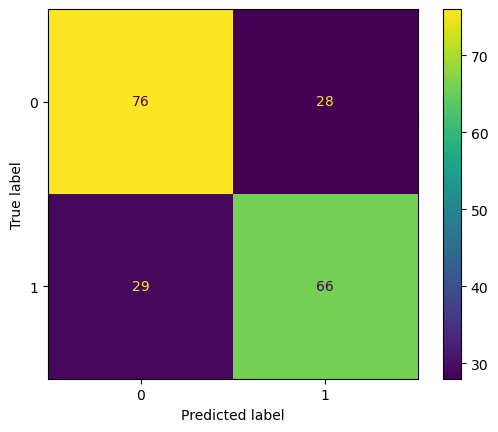

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")

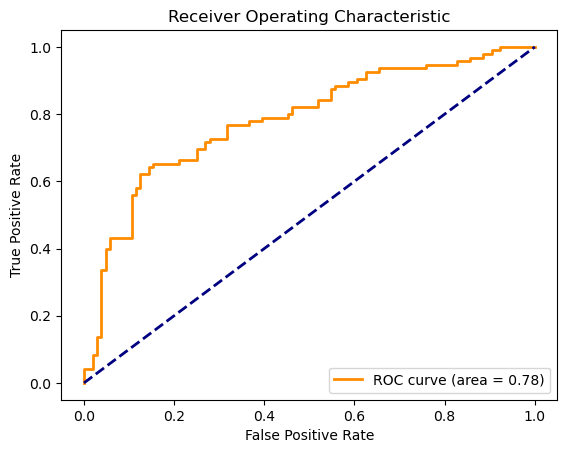

In [23]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")

C:\Users\Jean\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🏃 View run mysterious-loon-928 at: http://127.0.0.1:5000/#/experiments/0/runs/87047b31ab02485693b2e322bb3e37db
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5357 - loss: 0.7921 - val_accuracy: 0.7085 - val_loss: 0.5890
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6833 - loss: 0.5840 - val_accuracy: 0.7136 - val_loss: 0.5593
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7353 - loss: 0.5155 - val_accuracy: 0.7538 - val_loss: 0.5007
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7897 - loss: 0.4509 - val_accuracy: 0.7588 - val_loss: 0.5020
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8225 - loss: 0.4014 - val_accuracy: 0.7839 - val_loss: 0.4794
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8574 - loss: 0.3098 - val_accuracy: 0.7789 - val_loss: 0.4804
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8681 - loss: 0.3011 - val_accuracy: 0.7688 - val_loss: 0.5117
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9075 - loss: 0.2410 - val_accuracy: 0.7688 - val_

2024/12/20 15:12:23 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/12/20 15:12:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
🏃 View run auspicious-rat-988 at: http://127.0.0.1:5000/#/experiments/0/runs/b66da5ab62ec42dfa44ccf2cc275fb2b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


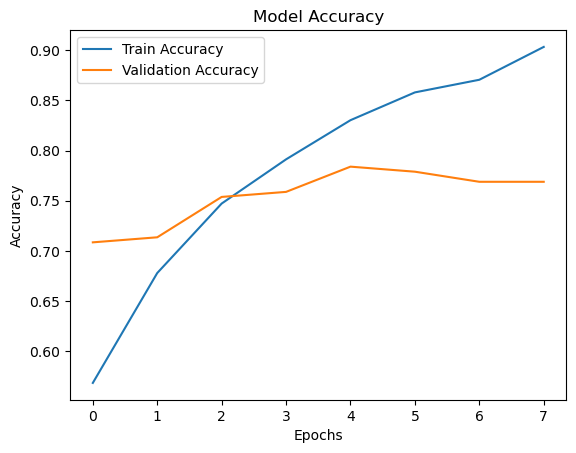

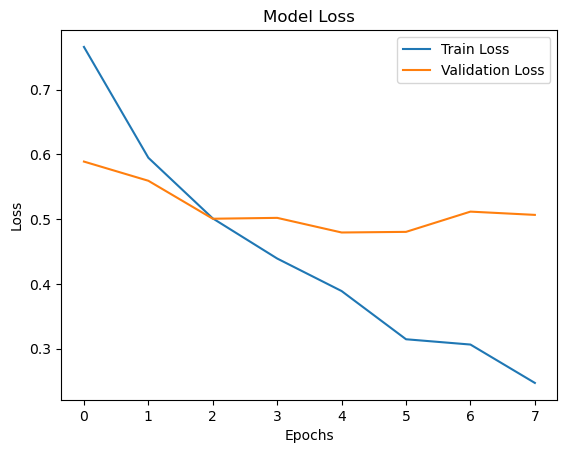

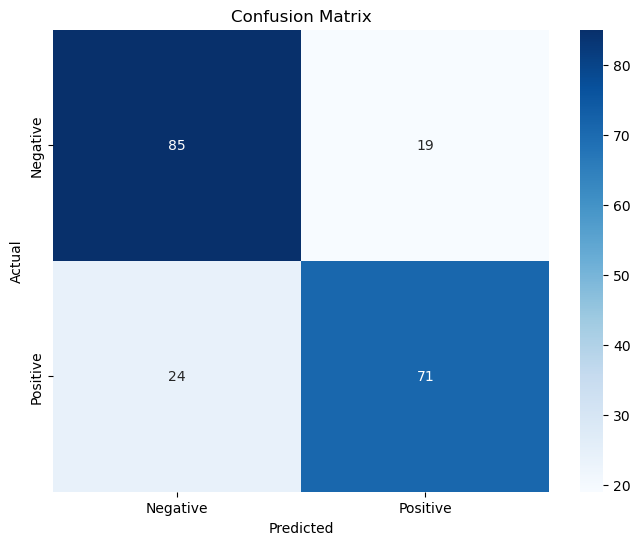

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# Define the path to the api/ folder relative to the script's location
api_folder = os.path.join(os.path.dirname(os.path.dirname(__file__)), "api")

# Ensure the api/ folder exists
os.makedirs(api_folder, exist_ok=True)

# Save the model in the api/ folder
model_save_path = os.path.join(api_folder, "sentiment_model.h5")

# Définir le modèle
model = Sequential()
model.add(Dense(256, input_dim=bert_embeddings.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compiler le modèle
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

if mlflow.active_run() is not None:
    mlflow.end_run()
# Enregistrer une nouvelle exécution dans MLflow
with mlflow.start_run():
    # Résumé du modèle
    model.summary(print_fn=lambda x: mlflow.log_text(x, "model_summary.txt"))
    
    # Entraîner le modèle
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    # Évaluation du modèle
    loss, accuracy = model.evaluate(X_test, y_test)
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_accuracy", accuracy)

    # Sauvegarder le modèle
    model.save(model_save_path)
    mlflow.keras.log_model(model, "model")
    
    # Enregistrer les graphiques
    # Courbes d'entraînement
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("accuracy_plot.png")
    mlflow.log_artifact("accuracy_plot.png")
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("loss_plot.png")
    mlflow.log_artifact("loss_plot.png")
    
    # Matrice de confusion
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Classification report
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
    mlflow.log_text(report, "classification_report.txt")

    # Log hyperparameters
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("dropout", 0.3)
    mlflow.log_param("batch_size", 64)
    mlflow.log_param("epochs", len(history.history['accuracy']))

In [25]:
# Prédire sur un nouvel échantillon
new_texts = ["This is a great day!", "I am so frustrated with this situation."]

# Extraire les embeddings BERT pour ces nouveaux textes
new_embeddings = get_bert_embeddings(new_texts)

# Charger le modèle sauvegardé
from tensorflow.keras.models import load_model
model = load_model("sentiment_model.h5")

# Prédire les sentiments
predictions = model.predict(new_embeddings)
predicted_labels = (predictions > 0.5).astype(int)  # Conversion des probabilités en labels binaires (0 ou 1)
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
[[1]
 [0]]


Mots les plus fréquents pour le label 0 (négatif) :
       Word  Count
7        im     79
8      just     41
9      like     33
19     work     32
12   really     30
0       day     28
10     miss     26
2      dont     25
6       got     20
16    think     20
5      good     19
4     going     19
1       did     16
11     need     16
13    right     16
14      sad     16
15    sorry     16
17     time     16
18    today     16
3   getting     15

Mots les plus fréquents pour le label 1 (positif) :
       Word  Count
8        im     44
9      just     40
4      good     37
12      lol     27
13     love     24
1       day     24
18     time     20
16   thanks     20
3     going     19
11     like     18
10     know     17
14      new     16
7     happy     15
6     great     15
5       got     15
2       fun     15
15    night     15
0       amp     14
17    think     14
19  twitter     14


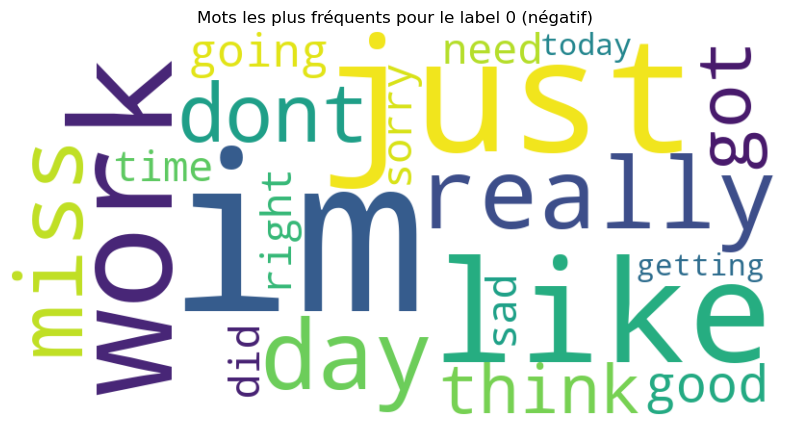

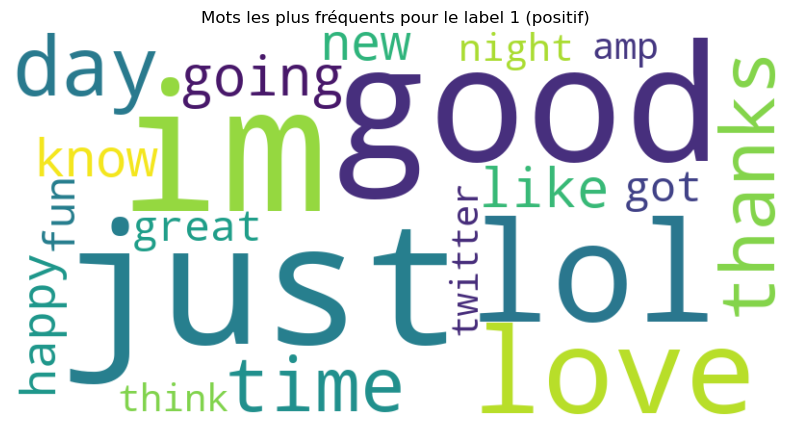

In [26]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

texts = df["text"].values  # Les tweets
labels = df["sentiment"].values  # Les labels de sentiment (0 ou 1)

# Gérer les valeurs NaN dans les textes
df = df.dropna(subset=["text"])  # Supprimer les lignes avec NaN dans la colonne "text"
tweets_label_0 = df[df["sentiment"] == 0]["text"]
tweets_label_1 = df[df["sentiment"] == 1]["text"]

# Fonction pour afficher les mots les plus fréquents
def get_most_frequent_words(texts, n_top=20):
    vectorizer = CountVectorizer(stop_words='english', max_features=n_top)
    X = vectorizer.fit_transform(texts)
    word_counts = X.toarray().sum(axis=0)
    words = vectorizer.get_feature_names_out()
    
    word_freq = pd.DataFrame(list(zip(words, word_counts)), columns=["Word", "Count"])
    word_freq = word_freq.sort_values(by="Count", ascending=False)
    
    return word_freq

# Analyser les mots les plus fréquents pour chaque label
word_freq_label_0 = get_most_frequent_words(tweets_label_0)
word_freq_label_1 = get_most_frequent_words(tweets_label_1)

# Afficher les résultats
print("Mots les plus fréquents pour le label 0 (négatif) :")
print(word_freq_label_0)

print("\nMots les plus fréquents pour le label 1 (positif) :")
print(word_freq_label_1)

# Afficher les nuages de mots
def plot_wordcloud(words, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(words["Word"], words["Count"])))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Nuages de mots pour les deux labels
plot_wordcloud(word_freq_label_0, "Mots les plus fréquents pour le label 0 (négatif)")
plot_wordcloud(word_freq_label_1, "Mots les plus fréquents pour le label 1 (positif)")


In [38]:
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Charger le modèle USE depuis TensorFlow Hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Fonction pour générer les embeddings
def get_use_embeddings(texts):
    return np.array(embed(texts))

X = df['text']
y = df['sentiment']
# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Générer les embeddings pour l'entraînement et le test
print("Génération des embeddings pour l'entraînement...")
X_train_embeddings = get_use_embeddings(X_train)
print("Génération des embeddings pour le test...")
X_test_embeddings = get_use_embeddings(X_test)

# Entraîner un modèle simple (régression logistique)
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_embeddings, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_embeddings)

# Évaluer les résultats
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Génération des embeddings pour l'entraînement...
Génération des embeddings pour le test...
Accuracy: 0.7286432160804021

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71        95
           1       0.74      0.75      0.74       104

    accuracy                           0.73       199
   macro avg       0.73      0.73      0.73       199
weighted avg       0.73      0.73      0.73       199



Accuracy: 0.7286432160804021

Classification Report:
               precision    recall  f1-score   support

    Negative       0.72      0.71      0.71        95
    Positive       0.74      0.75      0.74       104

    accuracy                           0.73       199
   macro avg       0.73      0.73      0.73       199
weighted avg       0.73      0.73      0.73       199



2024/12/20 15:31:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run inquisitive-goat-17 at: http://127.0.0.1:5000/#/experiments/0/runs/41ae555275b3485f8965477f3180eff1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0


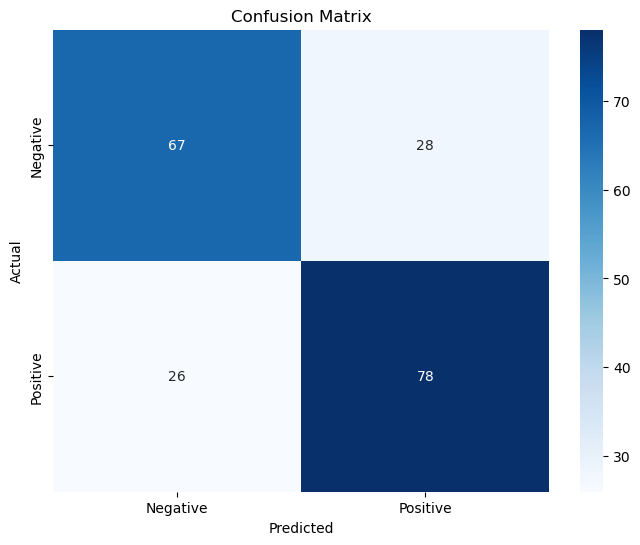

In [29]:
# Enregistrer dans MLflow
if mlflow.active_run() is not None:
    mlflow.end_run()

with mlflow.start_run():
    # Entraîner le modèle
    model.fit(X_train_embeddings, y_train)

    # Prédictions
    y_pred = model.predict(X_test_embeddings)

    # Évaluer les résultats
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
    
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)

    # Enregistrer les métriques et paramètres dans MLflow
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42)

    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(model, "logistic_regression_model")

    # Créer et enregistrer les graphiques
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig("confusion_matrix_use.png")
    mlflow.log_artifact("confusion_matrix_use.png")
    
    # Rapport de classification
    mlflow.log_text(report, "classification_report_use.txt")